In [15]:
#載入所需函示庫
from matplotlib import pyplot as plt
%matplotlib inline
# 設定圖形大小; DPI越大圖越大
plt.rcParams["figure.dpi"] = 120
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels.stats.outliers_influence as sso
import math
import statistics 
from scipy.optimize import curve_fit
import time
import itertools
from stepwise_regression import step_reg

In [16]:
def runsTest(l, l_median): 
    runs, n1, n2 = 1, 0, 0
    if(l[0]) >= l_median:
        n1 += 1   
    else:
        n2 += 1   
    for i in range(1, len(l)): 
        if (l[i] >= l_median and l[i-1] < l_median) or (l[i] < l_median and l[i-1] >= l_median):
            runs += 1  
        if(l[i]) >= l_median: 
            n1 += 1   
        else: 
            n2 += 1   
    runs_exp = ((2*n1*n2)/(n1+n2)) + 1
    stan_dev = math.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/(((n1+n2)**2)*(n1+n2-1))) 
    z = (runs-runs_exp)/stan_dev
    pval_z = stats.norm.sf(abs(z)) * 2
    print('runs = ', runs)
    print('n1 = ', n1)
    print('n2 = ', n2)
    print('runs_exp = ', runs_exp)
    print('stan_dev = ', stan_dev)
    print('z = ', z)
    print('pval_z = ', pval_z)
    return pval_z

def Chi_Square_for_Normality(stand_res, N, a): 
    m = np.mean(stand_res)
    s = np.std(stand_res, ddof=1)    
    prob_bins = np.zeros((N + 1))
    z_bins = np.zeros((N + 1))
    z_bins[0] = -4
    z_bins[N] = 4
    for i in range(0, N+1):
        prob_bins[i] = i/N
    for j in range(1, N):
        z_bins[j] = m + stats.norm.isf(1 - prob_bins[j]) * s
    counts, bins = np.histogram(stand_res, bins=z_bins)
    nobs = counts.sum()
    prob_e = np.zeros((N))
    for i in range(1, N+1):
        prob_e[i - 1] = prob_bins[i] - prob_bins[i - 1]
    freq_e = nobs * prob_e
    freq_o = counts
    if np.sum(freq_e < 5) > 0:
        print("Rule of five is not met. ")
    else:
        chi_stat, pval = stats.chisquare(freq_o, freq_e)
        chi_pval = stats.chi2.sf(chi_stat, N - 3)
        print("Chi-squared test: statistics = %0.4f, p-value = %0.4f" % (chi_stat, chi_pval))
    df = freq_o.shape[0]-3
    crit_value = stats.chi2.ppf(1 - a, df)
    print("Critical value = %0.4f (defree of freedom = %d)" % (crit_value, df))
    return chi_pval

def Durbin_Watson_test(x):
    x_square_sum = np.vdot(x, x)
    print("x_square_sum = ", x_square_sum)
    size = x.size
    print("size = ", size)
    x_d = np.zeros((size))
    print("x_d = ", x_d)
    l_size = size - 1
    for i in range(l_size):
        x_d[i + 1] = x[i + 1] - x[i]
    print("x_d = ", x_d)
    d = np.vdot(x_d, x_d) / x_square_sum
    print("d = ", d)
    return(d)

def processSubset(y_v, X_v, feature_set):
    X_v_a = sm.add_constant(X_v[list(feature_set)])
    model = sm.OLS(y_v,X_v_a)
    regr = model.fit()
    RSS = regr.rsquared_adj
    return {"model":regr, "RSS":RSS}

def getBest(y_g, X_g, k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X_g.columns, k):
        results.append(processSubset(y_g, X_g, combo))
    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].argmax()]
    toc = time.time()
    return best_model

In [17]:
def processSubset(y_v, X_v, feature_set):
    X_v_a = sm.add_constant(X_v[list(feature_set)])
    model = sm.OLS(y_v,X_v_a)
    regr = model.fit()
    RSS = regr.rsquared_adj
    return {"model":regr, "RSS":RSS}

def getBest(y_g, X_g, k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X_g.columns, k):
        results.append(processSubset(y_g, X_g, combo))
    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].argmax()]
    toc = time.time()
    return best_model

def my_inference(p_value, alpha, claim):
    if p_value < alpha:
        print(f"Since the p_value = {p_value:.4f} < {alpha}, we reject the null hypothesis.\nThat is, we have sufficient evidence to claim that {claim}.")
    else:
        print(f"Since the p_value = {p_value:.4f} > {alpha}, we do not reject the null hypothesis.\nThat is, we do not have sufficient evidence to claim that {claim}.")

def my_normality_check(sample_data, data_name, data_unit, alpha):
    # histogram
    fig, ax = plt.subplots()
    counts, bins, patches = plt.hist((sample_data.dropna()).astype(float), 6, density=False, facecolor='g', alpha=0.75)
    plt.title(f'Histogram of {data_name}')
    plt.xlabel(data_unit)
    plt.ylabel('Frequency')
    plt.grid(True)
    
    # Shapiro-Wilk test
    print("Shapiro-Wilk test for normality:")
    print("H0: The distribution is normal.")
    print("H1: The distribution is not normal.")
    stat, p = stats.shapiro(sample_data.dropna())
    print(f'For population = {data_name}')
    print(f"Shapiro statistic = {stat:.6f} and p_value = {p:.6f}")
    p_value = p; claim = "the distribution is not normal"
    my_inference(p_value, alpha, claim)
    
    # QQ plot
    fig = sm.qqplot(sample_data.dropna(), stats.norm, fit=True, line='45')
    plt.title(f'Q-Q Plot for {data_name}')
    plt.show()

def my_scatter_plot(sample_data, X_name, Y_name, X_unit, Y_unit):
    _ = sns.regplot(x = sample_data[X_name], y = sample_data[Y_name], color = 'b', ci = None)
    plt.title(f'Scatter Plot for {X_name} and {Y_name}')
    plt.xlabel(f'{X_name} ({X_unit})')
    plt.ylabel(f'{Y_name} ({Y_unit})')
    plt.show()
    
def Sample_Mean_Hypothesis_Testing(x, H0_x_bar, a):
    x_bar = x.mean()
    x_std = stat.stdev(x)
    x_n = x.size
    print(f"mean = {x_bar:.4f}")
    print(f"std. dev. = {x_std:.4f}")
    print(f"Number of observation = {x_n}")
    print(f"Hypothesized mean = {H0_x_bar}")
    print(f"Significant level = {a}")
    tstat = (x_bar - H0_x_bar) / (x_std / (x_n ** 0.5))
    print(f"t-stat = {tstat:.4f}")
    if tstat > 0:
        tcv_onetail = stats.t.ppf(1 - a, df = x_n - 1)
    else:
        tcv_onetail = stats.t.ppf(a, df = x_n - 1)    
    print(f"t critical value one tail = {tcv_onetail:.4f}")
    if tstat > 0:
        p_onetail = 1 - stats.t.cdf(tstat, df = x_n - 1)
    else:
        p_onetail = stats.t.cdf(tstat, df = x_n - 1)
    print(f"p-value (one-tail) = {p_onetail:.4f}")
    if tstat > 0:
        tcv_twotail = stats.t.ppf(1 - a/2, df = x_n - 1)
    else:
        tcv_twotail = stats.t.ppf(a/2, df = x_n - 1)
    print(f"t critical value two tail = {tcv_twotail:.4f}")
    p_twotail = p_onetail * 2
    print(f"p-value (two-tail) = {p_twotail:.4f}")
    return p_onetail, p_twotail

def runsTest(l, l_median): 
    runs, n1, n2 = 1, 0, 0
    if(l[0]) >= l_median:
        n1 += 1   
    else:
        n2 += 1   
    for i in range(1, len(l)): 
        if (l[i] >= l_median and l[i-1] < l_median) or (l[i] < l_median and l[i-1] >= l_median):
            runs += 1  
        if(l[i]) >= l_median: 
            n1 += 1   
        else: 
            n2 += 1   
    runs_exp = ((2*n1*n2)/(n1+n2)) + 1
    stan_dev = math.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/(((n1+n2)**2)*(n1+n2-1))) 
    z = (runs-runs_exp)/stan_dev
    pval_z = stats.norm.sf(abs(z)) * 2
    print('runs = ', runs)
    print('n1 = ', n1)
    print('n2 = ', n2)
    print('runs_exp = ', runs_exp)
    print('stan_dev = ', stan_dev)
    print('z = ', z)
    print('pval_z = ', pval_z)
    return pval_z

def Durbin_Watson_test(x):
    x_square_sum = np.vdot(x, x)
    print("x_square_sum = ", x_square_sum)
    size = x.size
    print("size = ", size)
    x_d = np.zeros((size))
    print("x_d = ", x_d)
    l_size = size - 1
    for i in range(l_size):
        x_d[i + 1] = x[i + 1] - x[i]
    print("x_d = ", x_d)
    d = np.vdot(x_d, x_d) / x_square_sum
    print("d = ", d)
    return(d)

def required_conditions_for_error(SD, y_pre, Y_name):
    # check required conditions
    print('Checking for required conditions for error variable:\n')

    mu = np.mean(SD)
    sigma = np.std(SD)
    
    ## The error is a random variable with mean of zero.
    print('\n1. Zero mean')
    print(f'H0: Errors have zero mean.')
    print(f'H1: Errors do not have zero mean.')
    H0_x_bar = 0
    p_onetail, p_twotail = Sample_Mean_Hypothesis_Testing(SD, H0_x_bar, alpha)
    claim = "the errors do not have zero mean"
    my_inference(p_twotail, alpha, claim)
    
    print(f'\n2. Normality')
    print(f'H0: Errors are normally distributed.')
    print(f'H1: Errors are not normally distributed.')
    
    
    ## The error is a normally distributed random variable.
    my_normality_check(pd.Series(SD), "standarized residuals", "unit", alpha)
    
    ## The variance of the error term is the same for all values of the independent variable.
    print('\n3. Homoskedasticity')
    print('H0: Homoskedasticity')
    print('H1: Heteroskedasticity')
    
    plt.plot(y_pre, SD, 'o', color = 'gray')
    plt.axhline(y=0, color = 'blue')
    plt.axhline(y=2, color = 'red')
    plt.axhline(y=-2, color = 'red')
    plt.title('Standardized Residual Plot')
    plt.xlabel(Y_name)
    plt.ylabel('Standardized Residual')
    plt.show()
    print('Do not rejected H0. Heteroscedasticity does not appear to be a problem.')
    
    
    ## The values of the error are independent
    print('\n4. Independence')
    print('\n4-1. Randomness')
    print('H0 : Randomness exists.')
    print('H1 : Randomness does not exist.')
    SD_median = statistics.median(SD)
    Z_pval = runsTest(SD, SD_median)
    print('p_value for Z-statistic= ', Z_pval)
    claim = 'randomness does not exist'
    my_inference(Z_pval, alpha, claim)
    
    print('\n4-2. No Autocorrelation')
    print('H0 : There is no first-order correlation.')
    print('H1 : There is first-order correlation.')
    
#     d = Durbin_Watson_test(x)
    
def my_multicollinearity_test(y, X):
    data = pd.concat([y, X], axis=1)
    corr = data.corr()
    _ = sns.heatmap(corr, annot=True)
    multicollinearity_pairs = []
    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if (corr.iloc[i, j] > 0.7):
                multicollinearity_pairs.append((corr.columns[i], corr.columns[j]))
    if len(multicollinearity_pairs) == 0:
        print("Multicollinearity will not be a problem.")
    else:
        print(f"Multicollinearity exists between {multicollinearity_pairs}.")
    return multicollinearity_pairs

def my_outlier(SD):
    df = pd.DataFrame(SD,columns = ['SD'])
    filter = (df['SD'] < -2) | (df['SD'] > 2)
    outliers = df['SD'].loc[filter]
    if len(outliers) == 0:
        print('There are no outliers.')
    else:
        print("Outliers by SD = \n")
        print(outliers)
        print('\nOutliers:')
        out = ''
        indices = outliers.index
        for i, idx in enumerate(indices):
            if i == len(indices) - 1:
                out += f'sample {idx + 1}.'
            else:
                out += f'sample {idx + 1}, '
        print(out)
        
def my_hii(X, ols_result):
    H = np.matmul(X, np.linalg.solve(np.matmul(X.T, X), X.T))
    df_h = pd.DataFrame({
        'hii': np.diagonal(H)
    })
    k = ols_result.df_model
    n = len(df_h['hii'])
    h_level = 3 * (k + 1) / n 
    print("h_level = ", h_level)
    print(" \n")
    filter = (df_h['hii'] > h_level )
    hii = df_h['hii']
    inf_hii = hii.loc[filter]
    if len(inf_hii) == 0:
        print('There are no influential observations by hii.')
    else:
        print("Influential observations by hii = \n")
        print(inf_hii)
        print('\Influential observations:')
        out = ''
        indices = inf_hii.index
        for i, idx in enumerate(indices):
            if i == len(indices) - 1:
                out += f'sample {idx + 1}.'
            else:
                out += f'sample {idx + 1}, '
    return hii, inf_hii
    

def my_cooks_distance(ols_result, data, hii):
    s2_e = ols_result.mse_resid
    k = ols_result.df_model
    y_a = data[:, 1]
    y_f = data[:, 2]
    CD_arr = np.square(y_a - y_f) / s2_e / (k - 1) * hii / np.square(1 - hii)
    CD = np.array(CD_arr)
    df_cd = pd.DataFrame(CD,columns = ['CD'])
    filter = (df_cd['CD'] > 1 )
    inf_cd = df_cd['CD'].loc[filter]
    
    if len(inf_cd) == 0:
        print("There are no influential observations by Cook's Distances.")
    else:
        print("Influential observations by Cook's Distances = \n")
        print(inf_cd)
        print('\Influential observations:')
        out = ''
        indices = inf_cd.index
        for i, idx in enumerate(indices):
            if i == len(indices) - 1:
                out += f'sample {idx + 1}.'
            else:
                out += f'sample {idx + 1}, '
    return inf_cd

def my_simple_linear_regression(sample_data, X_name, Y_name, X_unit, Y_unit, alpha):
    # scatter plot
    my_scatter_plot(sample_data, X_name, Y_name, X_unit, Y_unit)
    
    # ols regression
    ols_result = smf.ols(f'{Y_name} ~ {X_name}', data = sample_data).fit()  
    display(ols_result.summary())
    b1 = ols_result.params[1]
    b0 = ols_result.params[0]
    print(f"Estimated model: {Y_name} = {b0:0.4f} + {b1:0.4f} {X_name}")
    
    ## interpret the model
    print(f'The intercept is b0 = {b0:0.4f}.')
    print(f'The slope of the line is b1 = {b1:0.4f}. For each additional {X_unit} on {X_name}, \
          {Y_name} decreases by an average of {b1:0.4f} {Y_unit}.')
    

    
    # check required conditions
    
    ## required conditions for error term
    st, data, ss = sso.summary_table(ols_result, alpha = alpha)
    SD = data[:, 10]
    y_pre = data[:, 2]
    
    required_conditions_for_error(SD, y_pre, Y_name)
    
    # detecting outliers
    my_outlier(SD)
    
    # influential observations
    ## hii
    hii, inf_hii = my_hii(sample_data.drop(sample_data.columns[0], axis = 1) , ols_result)
    
    ## cook's distance
    my_cooks_distance(ols_result, data, hii)
    
    # assessing the model
    print('Assessing the model:')
    ## standard error of estimate
    print('Assessment 1: standard error of estimate')
    s2_e = ols_result.mse_resid
    print(f'MSE: {s2_e:.4f}')
    s_e = ols_result.mse_resid ** 0.5
    print(f'Standard errors: {s_e:.4f}')
    print(f"mean of y = {sample_data[Y_name].mean():.4f}")
    print(f"variance of y = {sample_data[Y_name].var(ddof=1):.4f}")
    print(f"standard deviation of y = {sample_data[Y_name].std(ddof=1):.4f}")


    ## using descriptive measurements, r2 and r
    print('Assessment 2: using descriptive measurements, r2 and r')
    r, pvalue = stats.pearsonr(sample_data[Y_name], sample_data[X_name])
    print("r = ", r)
    print("r^2 = ", r**2)
     
    
    ## testing and/or estimating the coefficients
    print('Assessment 3: testing and/or estimating the coefficients')

def my_multiple_linear_regression(y, X, alpha):
    Y_name = y.name
    
    ## no muliticollinearity
    multicollinearity_pairs = my_multicollinearity_test(y, X)
    
    # ols regression
#     regression_str = Y_name + " ~ "
#     for idx, x_name in enumerate(X.columns):
#         if idx == 0:
#             regression_str += x_name
#         else:
#             regression_str += f" + {x_name}"
#     print(regression_str)
    X = sm.add_constant(X)
    
    ols_result = sm.OLS(y, X).fit()
    display(ols_result.summary())
    
    # check required conditions
    
    ## required conditions for error term
    st, data, ss = sso.summary_table(ols_result, alpha = alpha)
    SD = data[:, 10]
    y_pre = data[:, 2]
    required_conditions_for_error(SD, y_pre, y.name)
    
    # detecting outliers
    my_outlier(SD)
    
    # influential observations
    ## hii
    hii, inf_hii = my_hii(X, ols_result)
    
    ## cook's distance
    my_cooks_distance(ols_result, data, hii)
    
    
    print('\nAssessing the model:')
    
    ## The Standard Error of Estimate 
    print('\nAssessment 1: standard error of estimate')
    s2_e = ols_result.mse_resid
    print(f'MSE: {s2_e:.4f}')
    s_e = ols_result.mse_resid ** 0.5
    print(f'Standard errors: {s_e:.4f}')
    print(f"mean of y = {y.mean():.4f}")
    print(f"variance of y = {y.var(ddof=1):.4f}")
    print(f"standard deviation of y = {y.std(ddof=1):.4f}")
    
    ## The Coefficient of Determination
    print('\nAssessment 2: Coefficient of Determination')
    print(f"R-squared: {ols_result.rsquared}")
    print(f"Adjusted R-squared: {ols_result.rsquared_adj}")
    if abs(ols_result.rsquared - ols_result.rsquared_adj) > 0.06:
        print(f'Since the difference between R-squared and the adjusted R-squared is {abs(ols_result.rsquared - ols_result.rsquared_adj):.4f} > 0.06, there might be a problem of over-fitting.')
    else:
        print(f'Since the difference between R-squared and the adjusted R-squared is {abs(ols_result.rsquared - ols_result.rsquared_adj):.4f} <= 0.06, there will not be a problem of over-fitting.')
    
    ## The F-test of ANOVA
    f_res = ols_result.fvalue
    print("F value = ", f_res)
    MSE = ols_result.mse_resid
    df_model = ols_result.df_model
    df_error = ols_result.df_resid
    MSR = f_res * MSE
    SSR = MSR * df_model
    print("SSR = ", SSR, "df = ", df_model, "MSR = ", MSR)
    print("SSE = ", MSE * df_error, "df = ", df_error, "MSE = ", MSE)
    print("F = ", MSR / MSE)
    A = np.identity(len(ols_result.params))
    A = A[1:,:]
    print("F test = ", ols_result.f_test(A))
    p_value = ols_result.f_pvalue
    claim = 'the model is valid'
    my_inference(p_value, alpha, claim)
    return ols_result
    
    ## Testing of the Coefficients
#     print('\nAssessment 3: testing and/or estimating the coefficients')

In [8]:
statistic = pd.read_excel("nba_stats_v3.xlsx")
print('Head of dataset:')
display(statistic.head())
print("Tail of dataset:")
display(statistic.tail())

Head of dataset:


,Age,G,GS,MP,3P%,STL,PF,Level1,Level2,PosCtg,...,log3P,log2P,log2PA,logFT,logFTA,logDRB,logTRB,logAST,logTOV,logPTS
0,20,18,0,3.7,0.280,0.1,0.2,1,0,F,...,0.336472,0.182322,0.262364,0.095310,0.182322,0.262364,0.336472,0.262364,0.182322,0.955511
1,22,17,8,21.6,0.375,0.4,1.4,0,1,F,...,0.530628,0.875469,1.193922,0.693147,0.916291,1.252763,1.504077,0.641854,0.405465,1.931521
2,23,40,0,14.2,0.308,0.7,1.5,0,0,G,...,0.470004,1.064711,1.410987,0.587787,0.641854,0.788457,0.916291,1.435085,0.832909,1.987874
3,28,75,74,33.5,0.461,0.9,2.1,0,1,G,...,1.308333,1.029619,1.435085,0.993252,1.098612,1.458615,1.589235,1.386294,0.832909,2.674149
4,31,60,3,16.9,0.366,0.4,2.1,1,0,C,...,0.336472,1.163151,1.547563,0.470004,0.587787,1.308333,1.629241,0.693147,0.530628,1.987874


Tail of dataset:


,Age,G,GS,MP,3P%,STL,PF,Level1,Level2,PosCtg,...,log3P,log2P,log2PA,logFT,logFTA,logDRB,logTRB,logAST,logTOV,logPTS
461,24,31,11,18.1,0.330,0.4,1.6,0,1,F,...,0.693147,1.029619,1.386294,0.470004,0.530628,1.029619,1.223775,0.530628,0.530628,2.104134
462,23,60,2,12.4,0.286,0.4,1.7,1,0,F,...,0.095310,0.916291,1.280934,0.336472,0.530628,0.916291,1.163151,0.641854,0.405465,1.547563
463,26,28,1,13.9,0.451,0.2,1.1,0,0,F,...,0.916291,0.262364,0.587787,0.405465,0.405465,0.788457,0.875469,0.470004,0.530628,1.856298
464,21,8,0,4.9,0.429,0.1,0.5,0,1,G,...,0.336472,0.262364,0.470004,0.336472,0.405465,0.693147,0.832909,0.832909,0.262364,1.098612
465,26,4,0,16.0,0.200,1.0,0.8,0,1,F,...,0.405465,0.000000,0.916291,0.000000,0.000000,1.098612,1.386294,0.262364,0.405465,0.916291


In [9]:
forward = statistic[statistic["PosCtg"] == "F"]
guard = statistic[statistic["PosCtg"] == "G"]
center = statistic[statistic["PosCtg"] == "C"]
display(forward.head())
print('Head of dataset:')
display(guard.head())
print('Head of dataset:')
display(center.head())

,Age,G,GS,MP,3P%,STL,PF,Level1,Level2,PosCtg,...,log3P,log2P,log2PA,logFT,logFTA,logDRB,logTRB,logAST,logTOV,logPTS
0,20,18,0,3.7,0.280,0.1,0.2,1,0,F,...,0.336472,0.182322,0.262364,0.095310,0.182322,0.262364,0.336472,0.262364,0.182322,0.955511
1,22,17,8,21.6,0.375,0.4,1.4,0,1,F,...,0.530628,0.875469,1.193922,0.693147,0.916291,1.252763,1.504077,0.641854,0.405465,1.931521
8,28,82,4,24.5,0.407,0.8,2.3,0,1,F,...,0.788457,1.704748,2.219203,0.788457,0.916291,1.902108,2.128232,0.832909,0.741937,2.694627
9,31,84,42,25.7,0.386,0.8,2.0,0,1,F,...,1.280934,1.029619,1.481605,0.470004,0.530628,1.252763,1.435085,1.335001,0.788457,2.572612
14,31,76,3,22.1,0.345,0.5,1.3,0,1,F,...,0.741937,0.641854,0.875469,0.470004,0.587787,1.252763,1.410987,1.131402,0.470004,1.887070


Head of dataset:


,Age,G,GS,MP,3P%,STL,PF,Level1,Level2,PosCtg,...,log3P,log2P,log2PA,logFT,logFTA,logDRB,logTRB,logAST,logTOV,logPTS
2,23,40,0,14.2,0.308,0.7,1.5,0,0,G,...,0.470004,1.064711,1.410987,0.587787,0.641854,0.788457,0.916291,1.435085,0.832909,1.987874
3,28,75,74,33.5,0.461,0.9,2.1,0,1,G,...,1.308333,1.029619,1.435085,0.993252,1.098612,1.458615,1.589235,1.386294,0.832909,2.674149
5,22,82,4,20.2,0.384,0.5,1.7,0,1,G,...,0.587787,1.064711,1.589235,0.741937,0.955511,1.335001,1.547563,0.955511,0.530628,2.116256
7,32,66,66,32.7,0.429,0.9,1.9,0,0,G,...,1.526056,1.547563,2.140066,0.993252,1.131402,1.547563,1.667707,1.722767,0.993252,3.044522
10,34,72,72,34.3,0.381,1.1,1.8,1,0,G,...,1.280934,1.193922,1.722767,1.648659,1.757858,1.740466,1.808289,2.251292,1.280934,2.867899


Head of dataset:


,Age,G,GS,MP,3P%,STL,PF,Level1,Level2,PosCtg,...,log3P,log2P,log2PA,logFT,logFTA,logDRB,logTRB,logAST,logTOV,logPTS
4,31,60,3,16.9,0.366,0.4,2.1,1,0,C,...,0.336472,1.163151,1.547563,0.470004,0.587787,1.308333,1.629241,0.693147,0.530628,1.987874
6,25,75,49,25.3,0.333,1.2,2.8,1,0,C,...,0.000000,1.410987,1.757858,0.916291,1.131402,1.808289,2.230014,1.252763,0.788457,2.174752
11,25,7,2,15.3,0.200,0.4,2.1,1,0,C,...,0.095310,0.741937,1.629241,0.000000,0.262364,1.458615,1.856298,0.262364,0.336472,1.308333
30,31,43,0,7.4,0.333,0.2,1.0,0,0,C,...,0.000000,0.470004,0.875469,0.405465,0.641854,0.916291,1.280934,0.641854,0.336472,1.029619
37,25,57,17,13.0,0.391,0.4,1.8,1,0,C,...,0.336472,0.832909,1.223775,0.470004,0.641854,1.335001,1.648659,0.530628,0.530628,1.686399


# all

In [10]:
y_varS = statistic['logSalary']
X_dataS2_ar = np.array([statistic['Age'], statistic['G'], statistic['GS'], statistic['MP'], 
                       statistic['logFG'], statistic['logFGA'],
                       statistic['log2P'], statistic['log2PA'], statistic['logFT'], statistic['logFTA'], 
                       statistic['logDRB'], statistic['logTRB'], statistic['logAST'], statistic['STL'], 
                       statistic['logTOV'], statistic['PF'], statistic['logPTS']])
X_dataS2_T = X_dataS2_ar.T
X_varS2 = pd.DataFrame(X_dataS2_T, columns = ['Age', 'G', 
                                            'GS', 'MP', 'logFG', 'logFGA', 
                                            'log2P', 'log2PA', 
                                            'logFT', 'logFTA',
                                            'logDRB', 'logTRB', 'logAST', 'STL', 
                                            'logTOV', 'PF', 'logPTS'])

In [ ]:
y_varS = statistic['logSalary']
X_dataS2_ar = np.array([statistic['Age'], statistic['G'], statistic['GS'], statistic['MP'], 
                       statistic['logFG'], statistic['logFGA'],
                       statistic['log2P'], statistic['log2PA'], statistic['logFT'], statistic['logFTA'], 
                       statistic['logDRB'], statistic['logTRB'], statistic['logAST'], statistic['STL'], 
                       statistic['logTOV'], statistic['PF'], statistic['logPTS']])
X_dataS2_T = X_dataS2_ar.T
X_varS2 = pd.DataFrame(X_dataS2_T, columns = ['Age', 'G', 
                                            'GS', 'MP', 'logFG', 'logFGA', 
                                            'log2P', 'log2PA', 
                                            'logFT', 'logFTA',
                                            'logDRB', 'logTRB', 'logAST', 'STL', 
                                            'logTOV', 'PF', 'logPTS'])
#X_varC.index = y_varC['index']
print(y_varS)
display(X_varS2.head())
display(X_varS2.tail())
models_best = pd.DataFrame(columns=["RSS", "model"])
tic = time.time()
for i in range(1,6):
    models_best.loc[i] = getBest(y_varS, X_varS2, i)
    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    Fb = models_best[models_best['RSS']==models_best.RSS.max()].index.values
    print(models_best.loc[Fb[0], "model"].summary())

0      15.430299
1      12.598037
2      14.408717
3      16.004367
4      16.024706
         ...    
461    14.578333
462    14.473383
463    14.538111
464    13.235303
465    13.463894
Name: logSalary, Length: 466, dtype: float64


,Age,G,GS,MP,logFG,logFGA,log2P,log2PA,logFT,logFTA,logDRB,logTRB,logAST,STL,logTOV,PF,logPTS
0,20.0,18.0,0.0,3.7,0.470004,0.993252,0.182322,0.262364,0.095310,0.182322,0.262364,0.336472,0.262364,0.1,0.182322,0.2,0.955511
1,22.0,17.0,8.0,21.6,1.131402,1.648659,0.875469,1.193922,0.693147,0.916291,1.252763,1.504077,0.641854,0.4,0.405465,1.4,1.931521
2,23.0,40.0,0.0,14.2,1.252763,1.791759,1.064711,1.410987,0.587787,0.641854,0.788457,0.916291,1.435085,0.7,0.832909,1.5,1.987874
3,28.0,75.0,74.0,33.5,1.704748,2.312535,1.029619,1.435085,0.993252,1.098612,1.458615,1.589235,1.386294,0.9,0.832909,2.1,2.674149
4,31.0,60.0,3.0,16.9,1.280934,1.774952,1.163151,1.547563,0.470004,0.587787,1.308333,1.629241,0.693147,0.4,0.530628,2.1,1.987874


,Age,G,GS,MP,logFG,logFGA,log2P,log2PA,logFT,logFTA,logDRB,logTRB,logAST,STL,logTOV,PF,logPTS
461,24.0,31.0,11.0,18.1,1.335001,1.945910,1.029619,1.386294,0.470004,0.530628,1.029619,1.223775,0.530628,0.4,0.530628,1.6,2.104134
462,23.0,60.0,2.0,12.4,0.955511,1.386294,0.916291,1.280934,0.336472,0.530628,0.916291,1.163151,0.641854,0.4,0.405465,1.7,1.547563
463,26.0,28.0,1.0,13.9,1.029619,1.609438,0.262364,0.587787,0.405465,0.405465,0.788457,0.875469,0.470004,0.2,0.530628,1.1,1.856298
464,21.0,8.0,0.0,4.9,0.470004,0.916291,0.262364,0.470004,0.336472,0.405465,0.693147,0.832909,0.832909,0.1,0.262364,0.5,1.098612
465,26.0,4.0,0.0,16.0,0.405465,1.609438,0.000000,0.916291,0.000000,0.000000,1.098612,1.386294,0.262364,1.0,0.405465,0.8,0.916291


Total elapsed time: 0.15127301216125488 seconds.
                            OLS Regression Results                            
Dep. Variable:              logSalary   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     510.6
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           8.47e-77
Time:                        01:25:20   Log-Likelihood:                -668.97
No. Observations:                 466   AIC:                             1342.
Df Residuals:                     464   BIC:                             1350.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

Multicollinearity exists between [('logSalary', 'MP'), ('MP', 'logFT')].


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              logSalary   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     239.1
Date:                Sun, 09 Jun 2024   Prob (F-statistic):          5.57e-111
Time:                        02:03:05   Log-Likelihood:                -580.17
No. Observations:                 466   AIC:                             1170.
Df Residuals:                     461   BIC:                             1191.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.8303      0.243     44.533      0.000      10.352      11.308
Age            0.0820      0.009      8.764      0.000       0.064       0.100
G              0.0202      0.002      9.593      0.000       0.016       0.024
MP             0.0319      0.008      4.068      0.000       0.016       0.047
logFT          0.8808      0.135      6.508      0.000       0.615       1.147
==============================================================================
Omnibus:                        4.625   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.099   Jarque-Bera (JB):                5.596
Skew:                          -0.079   Prob(JB):                       0.0609
Kurtosis:                       3.513   Cond. No.                         389.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Checking for required conditions for error variable:


1. Zero mean
H0: Errors have zero mean.
H1: Errors do not have zero mean.
mean = -0.0001
std. dev. = 1.0019
Number of observation = 466
Hypothesized mean = 0
Significant level = 0.05
t-stat = -0.0029
t critical value one tail = -1.6481
p-value (one-tail) = 0.4988
t critical value two tail = -1.9651
p-value (two-tail) = 0.9977
Since the p_value = 0.9977 > 0.05, we do not reject the null hypothesis.
That is, we do not have sufficient evidence to claim that the errors do not have zero mean.

2. Normality
H0: Errors are normally distributed.
H1: Errors are not normally distributed.
Shapiro-Wilk test for normality:
H0: The distribution is normal.
H1: The distribution is not normal.
For population = standarized residuals
Shapiro statistic = 0.995413 and p_value = 0.187431
Since the p_value = 0.1874 > 0.05, we do not reject the null hypothesis.
That is, we do not have sufficient evidence to claim that the distribution is not normal.


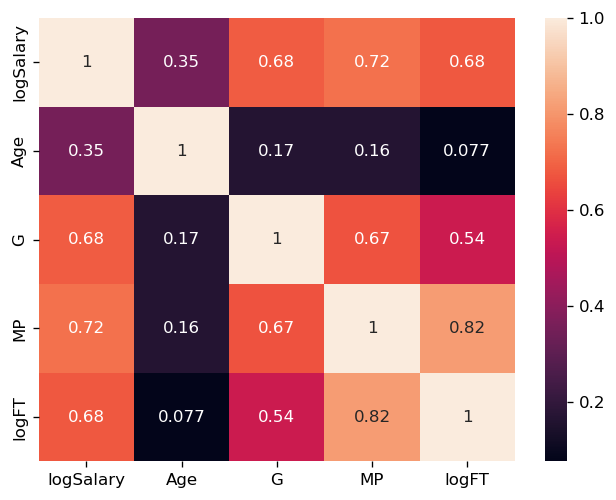

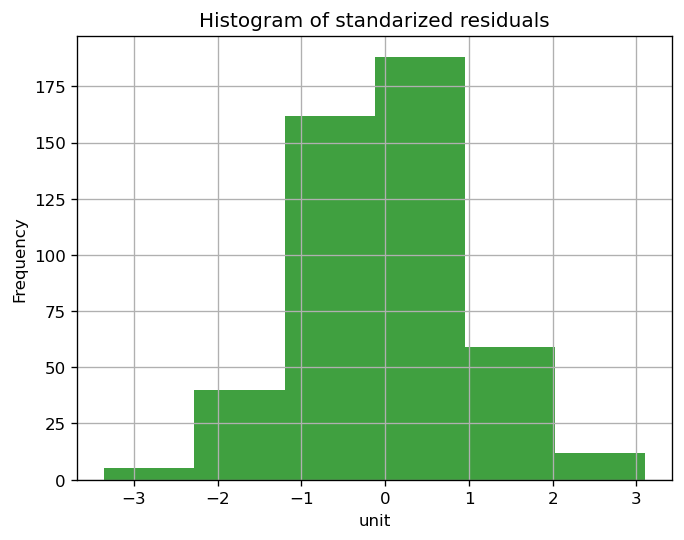

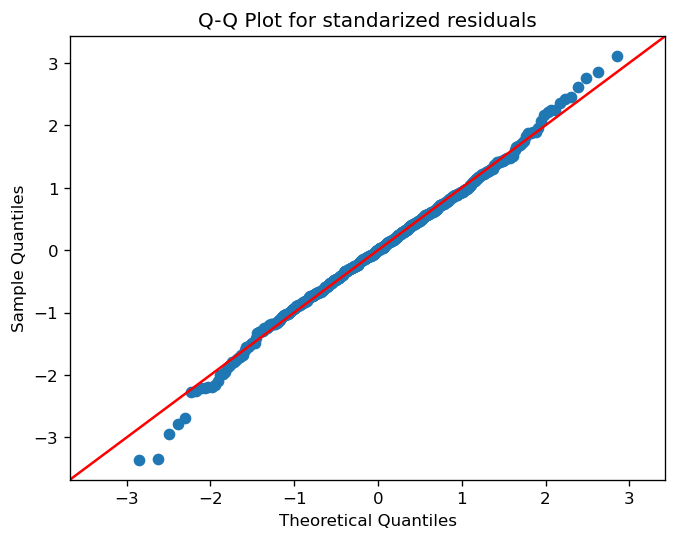


3. Homoskedasticity
H0: Homoskedasticity
H1: Heteroskedasticity


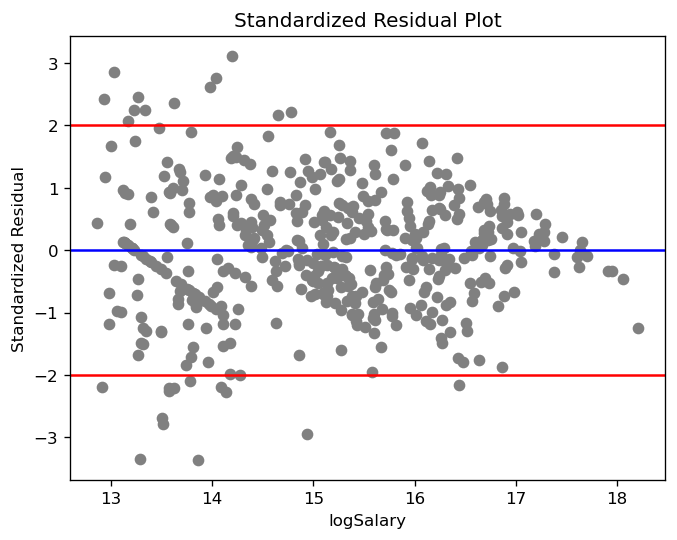

Do not rejected H0. Heteroscedasticity does not appear to be a problem.

4. Independence

4-1. Randomness
H0 : Randomness exists.
H1 : Randomness does not exist.
runs =  232
n1 =  233
n2 =  233
runs_exp =  234.0
stan_dev =  10.781904394196388
z =  -0.185495987246608
pval_z =  0.8528400273659733
p_value for Z-statistic=  0.8528400273659733
Since the p_value = 0.8528 > 0.05, we do not reject the null hypothesis.
That is, we do not have sufficient evidence to claim that randomness does not exist.

4-2. No Autocorrelation
H0 : There is no first-order correlation.
H1 : There is first-order correlation.
Outliers by SD = 

0      2.848020
11    -2.691922
26     2.455248
59     2.169467
90    -2.200240
143    2.764835
147   -2.265783
148   -2.788005
150    2.364780
157    2.614116
172    2.423879
218   -2.208838
244   -2.250167
270   -3.355419
276    2.240491
282   -2.092084
300   -3.348553
302   -2.191531
316   -2.953722
342   -2.210752
348    2.068063
353    3.106692
377    2.252292
386    2

/var/folders/v5/jn12r6jd76lc3czt8179yb400000gn/T/ipykernel_4921/738161940.py:218: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  H = np.matmul(X, np.linalg.solve(np.matmul(X.T, X), X.T))


In [19]:
s1 = np.array([statistic["Age"], statistic["G"], statistic["MP"], statistic["logFT"]])
s1 = pd.DataFrame(s1.T, columns = ["Age", "G", "MP", "logFT"])
alpha = 0.05
my_multiple_linear_regression(y_varS, s1, alpha)

# center

In [20]:
y_varC = center['logSalary'].reset_index()
X_dataC2_ar = np.array([center['Age'], center['G'], center['GS'], center['MP'], 
                       center['logFG'], center['logFGA'],
                       center['log2P'], center['log2PA'], center['logFT'], center['logFTA'], 
                       center['logDRB'], center['logTRB'], center['logAST'], center['STL'], 
                       center['logTOV'], center['PF'], center['logPTS']])
X_dataC2_T = X_dataC2_ar.T
X_varC2 = pd.DataFrame(X_dataC2_T, columns = ['Age', 'G', 
                                            'GS', 'MP', 'logFG', 'logFGA', 
                                            'log2P', 'log2PA', 
                                            'logFT', 'logFTA',
                                            'logDRB', 'logTRB', 'logAST', 'STL', 
                                            'logTOV', 'PF', 'logPTS'])

In [6]:
y_varC = center['logSalary'].values
X_dataC2_ar = np.array([center['Age'], center['G'], center['GS'], center['MP'], 
                       center['logFG'], center['logFGA'],
                       center['log2P'], center['log2PA'], center['logFT'], center['logFTA'], 
                       center['logDRB'], center['logTRB'], center['logAST'], center['STL'], 
                       center['logTOV'], center['PF'], center['logPTS']])
X_dataC2_T = X_dataC2_ar.T
X_varC2 = pd.DataFrame(X_dataC2_T, columns = ['Age', 'G', 
                                            'GS', 'MP', 'logFG', 'logFGA', 
                                            'log2P', 'log2PA', 
                                            'logFT', 'logFTA',
                                            'logDRB', 'logTRB', 'logAST', 'STL', 
                                            'logTOV', 'PF', 'logPTS'])
#X_varC.index = y_varC['index']
print(y_varC)
display(X_varC2.head())
display(X_varC2.tail())
models_best = pd.DataFrame(columns=["RSS", "model"])
tic = time.time()
for i in range(1,6):
    models_best.loc[i] = getBest(y_varC['logSalary'], X_varC2, i)
    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    Fb = models_best[models_best['RSS']==models_best.RSS.max()].index.values
    print(models_best.loc[Fb[0], "model"].summary())


[16.0247062  16.03960651 11.25431016 14.97755075 14.668484   15.85673089
 17.23651057 14.771022   16.21340583 15.20180492 14.76388971 16.85884181
 14.97755075 14.70129755 14.60852117 16.11809565 14.8073836  16.84157803
 17.5192806  14.80774626 14.84512998 14.50865774 14.668484   15.52836606
 17.67849772 17.29550181 15.28123513 15.85971345 14.76587996 15.02745153
 14.65126519 14.85619708 16.81124283 14.48396538 15.43366497 16.1559693
 14.40427952 15.05240224 17.03438638 14.69650732 14.58793092 14.51846251
 16.30424487 14.7430312  14.97755075 15.07858589 13.4407662  15.8949521
 15.8949521  15.42494847 14.54140804 14.97755075 16.31032133 16.31654659
 15.90849288 16.31371441 13.12661632 15.83041358 17.29982469 16.37663723
 13.2353027  17.52908262 13.2353027 ]


,Age,G,GS,MP,logFG,logFGA,log2P,log2PA,logFT,logFTA,logDRB,logTRB,logAST,STL,logTOV,PF,logPTS
0,31.0,60.0,3.0,16.9,1.280934,1.774952,1.163151,1.547563,0.470004,0.587787,1.308333,1.629241,0.693147,0.4,0.530628,2.1,1.987874
1,25.0,75.0,49.0,25.3,1.410987,1.774952,1.410987,1.757858,0.916291,1.131402,1.808289,2.230014,1.252763,1.2,0.788457,2.8,2.174752
2,25.0,7.0,2.0,15.3,0.832909,1.774952,0.741937,1.629241,0.000000,0.262364,1.458615,1.856298,0.262364,0.4,0.336472,2.1,1.308333
3,31.0,43.0,0.0,7.4,0.470004,0.875469,0.470004,0.875469,0.405465,0.641854,0.916291,1.280934,0.641854,0.2,0.336472,1.0,1.029619
4,25.0,57.0,17.0,13.0,0.993252,1.504077,0.832909,1.223775,0.470004,0.641854,1.335001,1.648659,0.530628,0.4,0.530628,1.8,1.686399


,Age,G,GS,MP,logFG,logFGA,log2P,log2PA,logFT,logFTA,logDRB,logTRB,logAST,STL,logTOV,PF,logPTS
58,26.0,71.0,71.0,34.0,2.140066,2.727853,2.116256,2.687847,1.629241,1.871802,2.208274,2.433613,1.589235,1.1,1.193922,2.2,3.010621
59,24.0,81.0,14.0,24.2,1.791759,2.442347,1.360977,1.871802,0.832909,1.029619,1.667707,1.824549,0.832909,0.8,0.875469,2.1,2.674149
60,24.0,15.0,0.0,6.5,0.530628,0.832909,0.470004,0.641854,0.530628,0.693147,0.993252,1.223775,0.095310,0.0,0.182322,1.2,1.193922
61,31.0,76.0,76.0,34.1,1.840550,2.208274,1.840550,2.197225,1.458615,1.808289,2.322388,2.631889,0.832909,0.7,0.955511,3.1,2.708050
62,25.0,20.0,0.0,2.5,0.405465,0.587787,0.262364,0.262364,0.095310,0.095310,0.405465,0.470004,0.095310,0.1,0.095310,0.5,0.788457


Total elapsed time: 0.09293985366821289 seconds.
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     76.15
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           2.50e-12
Time:                        01:25:56   Log-Likelihood:                -74.936
No. Observations:                  63   AIC:                             153.9
Df Residuals:                      61   BIC:                             158.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

Multicollinearity exists between [('logSalary', 'logPTS')].


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              logSalary   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     65.90
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           7.22e-16
Time:                        02:03:47   Log-Likelihood:                -63.849
No. Observations:                  63   AIC:                             133.7
Df Residuals:                      60   BIC:                             140.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.1805      0.676     13.573      0.000       7.828      10.533
Age            0.1172      0.021      5.565      0.000       0.075       0.159
logPTS         1.5097      0.139     10.857      0.000       1.232       1.788
==============================================================================
Omnibus:                       25.900   Durbin-Watson:                   2.363
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.979
Skew:                          -1.306   Prob(JB):                     1.90e-12
Kurtosis:                       6.707   Cond. No.                         214.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Checking for required conditions for error variable:


1. Zero mean
H0: Errors have zero mean.
H1: Errors do not have zero mean.
mean = -0.0008
std. dev. = 1.0059
Number of observation = 63
Hypothesized mean = 0
Significant level = 0.05
t-stat = -0.0060
t critical value one tail = -1.6698
p-value (one-tail) = 0.4976
t critical value two tail = -1.9990
p-value (two-tail) = 0.9952
Since the p_value = 0.9952 > 0.05, we do not reject the null hypothesis.
That is, we do not have sufficient evidence to claim that the errors do not have zero mean.

2. Normality
H0: Errors are normally distributed.
H1: Errors are not normally distributed.
Shapiro-Wilk test for normality:
H0: The distribution is normal.
H1: The distribution is not normal.
For population = standarized residuals
Shapiro statistic = 0.916557 and p_value = 0.000400
Since the p_value = 0.0004 < 0.05, we reject the null hypothesis.
That is, we have sufficient evidence to claim that the distribution is not normal.


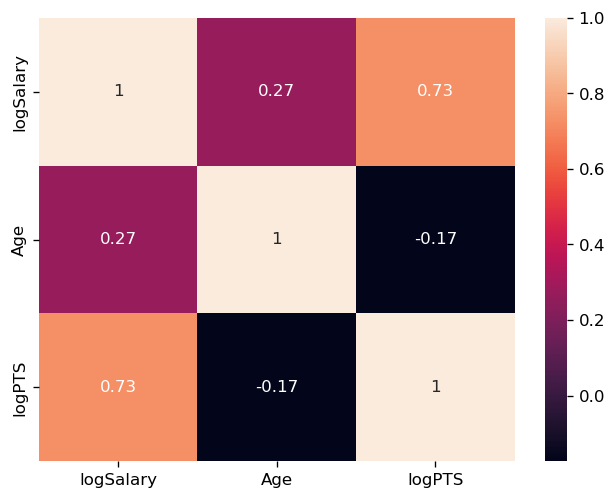

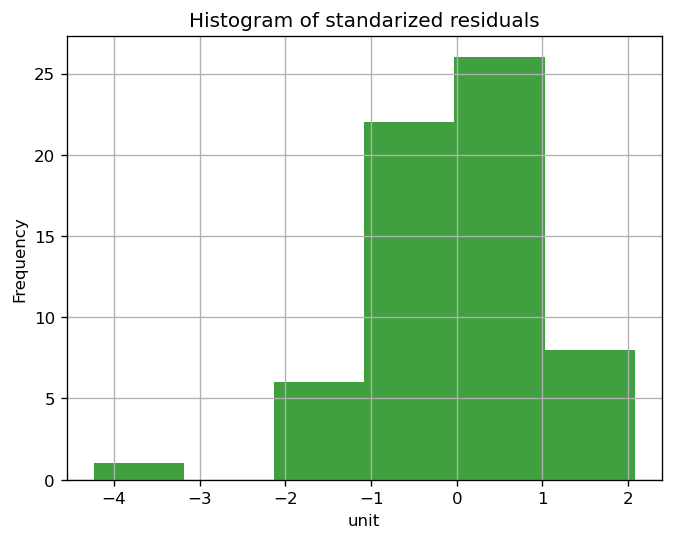

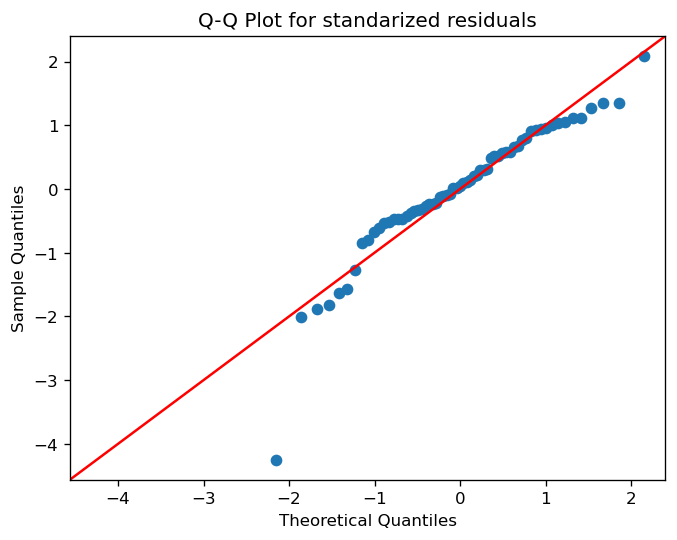


3. Homoskedasticity
H0: Homoskedasticity
H1: Heteroskedasticity


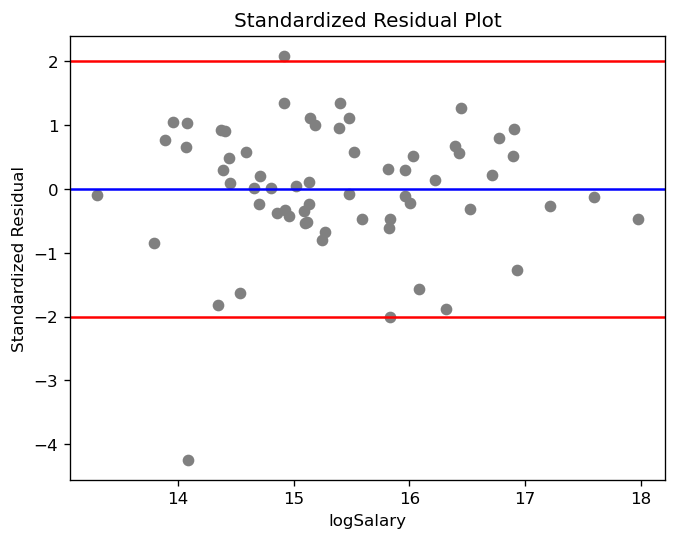

Do not rejected H0. Heteroscedasticity does not appear to be a problem.

4. Independence

4-1. Randomness
H0 : Randomness exists.
H1 : Randomness does not exist.
runs =  36
n1 =  32
n2 =  31
runs_exp =  32.492063492063494
stan_dev =  3.9354837377299643
z =  0.8913609461285508
pval_z =  0.3727355621275308
p_value for Z-statistic=  0.3727355621275308
Since the p_value = 0.3727 > 0.05, we do not reject the null hypothesis.
That is, we do not have sufficient evidence to claim that randomness does not exist.

4-2. No Autocorrelation
H0 : There is no first-order correlation.
H1 : There is first-order correlation.
Outliers by SD = 

2    -4.237555
52    2.076791
Name: SD, dtype: float64

Outliers:
sample 3, sample 53.
h_level =  0.14285714285714285
 

There are no influential observations by hii.
There are no influential observations by Cook's Distances.

Assessing the model:

Assessment 1: standard error of estimate
MSE: 0.4667
Standard errors: 0.6831
mean of y = 15.3834
variance of y = 1.44

/var/folders/v5/jn12r6jd76lc3czt8179yb400000gn/T/ipykernel_4921/738161940.py:218: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  H = np.matmul(X, np.linalg.solve(np.matmul(X.T, X), X.T))


In [21]:
C = np.array([center["Age"], center["logPTS"]])
C = pd.DataFrame(C.T, columns = ["Age","logPTS"])
alpha = 0.05
my_multiple_linear_regression(y_varC['logSalary'].T , C, 0.05)

Multicollinearity exists between [('logSalary', 'MP')].


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              logSalary   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     76.15
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           2.50e-12
Time:                        02:04:26   Log-Likelihood:                -74.936
No. Observations:                  63   AIC:                             153.9
Df Residuals:                      61   BIC:                             158.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.5751      0.231     58.801      0.000      13.114      14.037
MP             0.0999      0.011      8.726      0.000       0.077       0.123
==============================================================================
Omnibus:                       43.009   Durbin-Watson:                   2.155
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.706
Skew:                          -1.927   Prob(JB):                     1.04e-36
Kurtosis:                       9.948   Cond. No.                         45.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Checking for required conditions for error variable:


1. Zero mean
H0: Errors have zero mean.
H1: Errors do not have zero mean.
mean = 0.0008
std. dev. = 1.0063
Number of observation = 63
Hypothesized mean = 0
Significant level = 0.05
t-stat = 0.0067
t critical value one tail = 1.6698
p-value (one-tail) = 0.4973
t critical value two tail = 1.9990
p-value (two-tail) = 0.9947
Since the p_value = 0.9947 > 0.05, we do not reject the null hypothesis.
That is, we do not have sufficient evidence to claim that the errors do not have zero mean.

2. Normality
H0: Errors are normally distributed.
H1: Errors are not normally distributed.
Shapiro-Wilk test for normality:
H0: The distribution is normal.
H1: The distribution is not normal.
For population = standarized residuals
Shapiro statistic = 0.868080 and p_value = 0.000007
Since the p_value = 0.0000 < 0.05, we reject the null hypothesis.
That is, we have sufficient evidence to claim that the distribution is not normal.


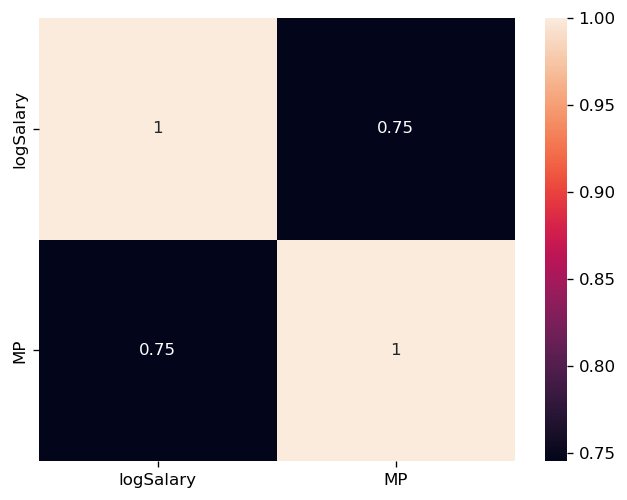

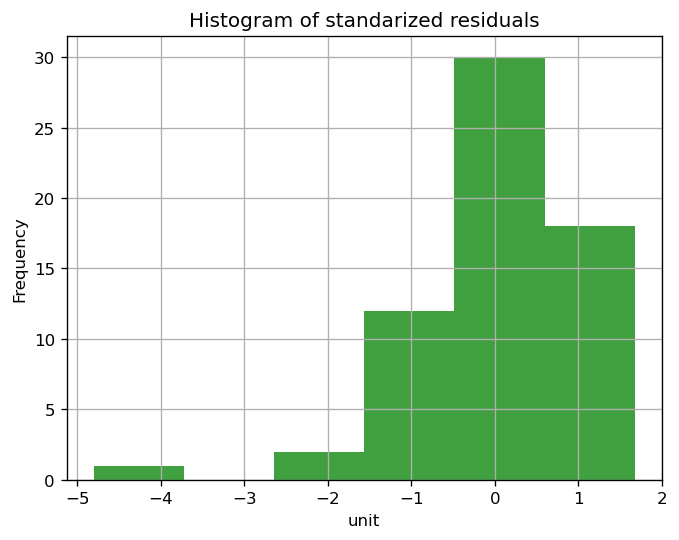

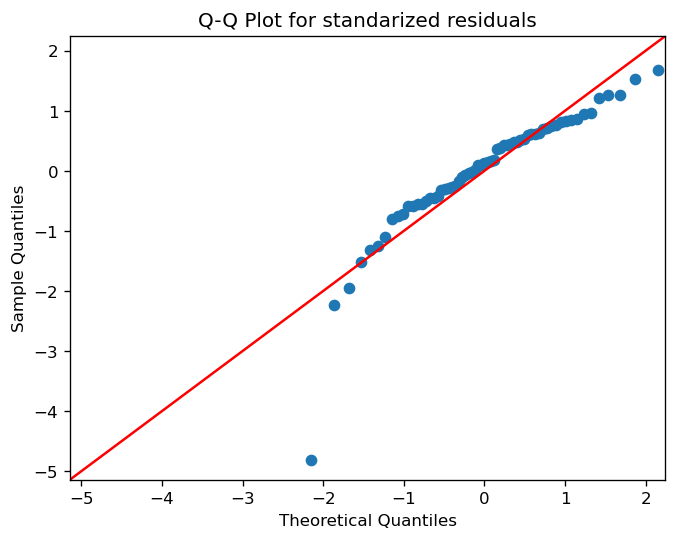


3. Homoskedasticity
H0: Homoskedasticity
H1: Heteroskedasticity


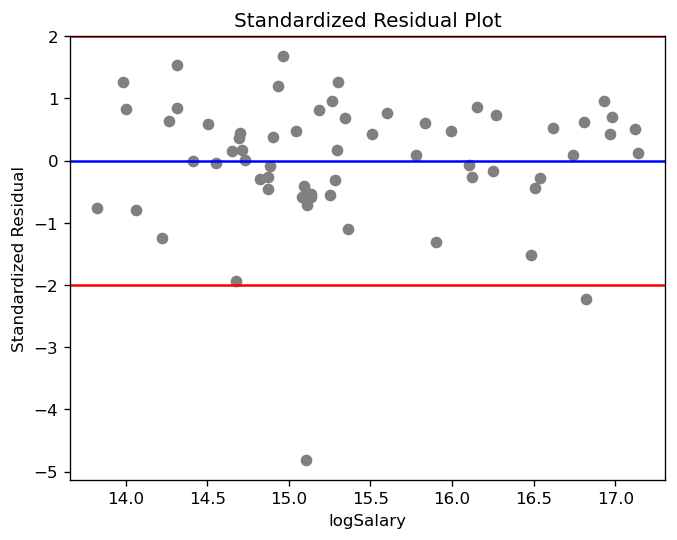

Do not rejected H0. Heteroscedasticity does not appear to be a problem.

4. Independence

4-1. Randomness
H0 : Randomness exists.
H1 : Randomness does not exist.
runs =  34
n1 =  32
n2 =  31
runs_exp =  32.492063492063494
stan_dev =  3.9354837377299643
z =  0.3831642076118202
pval_z =  0.7015980147481498
p_value for Z-statistic=  0.7015980147481498
Since the p_value = 0.7016 > 0.05, we do not reject the null hypothesis.
That is, we do not have sufficient evidence to claim that randomness does not exist.

4-2. No Autocorrelation
H0 : There is no first-order correlation.
H1 : There is first-order correlation.
Outliers by SD = 

2    -4.805924
45   -2.220597
Name: SD, dtype: float64

Outliers:
sample 3, sample 46.
h_level =  0.09523809523809523
 

There are no influential observations by hii.
Influential observations by Cook's Distances = 

0     inf
1     inf
2     inf
3     inf
4     inf
     ... 
58    inf
59    inf
60    inf
61    inf
62    inf
Name: CD, Length: 63, dtype: float64
\In

/var/folders/v5/jn12r6jd76lc3czt8179yb400000gn/T/ipykernel_4921/738161940.py:218: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  H = np.matmul(X, np.linalg.solve(np.matmul(X.T, X), X.T))
/var/folders/v5/jn12r6jd76lc3czt8179yb400000gn/T/ipykernel_4921/738161940.py:251: RuntimeWarning: divide by zero encountered in divide
  CD_arr = np.square(y_a - y_f) / s2_e / (k - 1) * hii / np.square(1 - hii)


In [22]:
C = np.array([center["MP"]])
C = pd.DataFrame(C.T, columns = ["MP"])
alpha = 0.05
my_multiple_linear_regression(y_varC['logSalary'].T , C, 0.05)

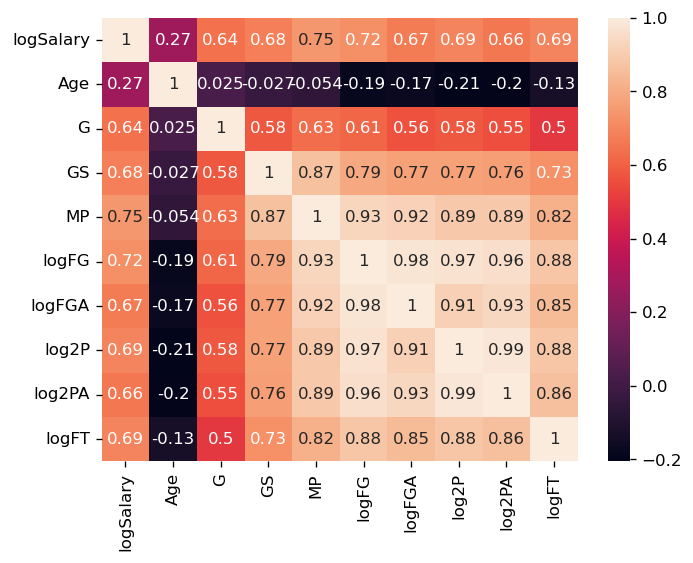

In [7]:
corrC1 = center[['logSalary', 'Age', 'G','GS', 'MP', 'logFG', 'logFGA','log2P', 'log2PA', 'logFT']].corr()
_ = sns.heatmap(corrC1, annot=True)                                        

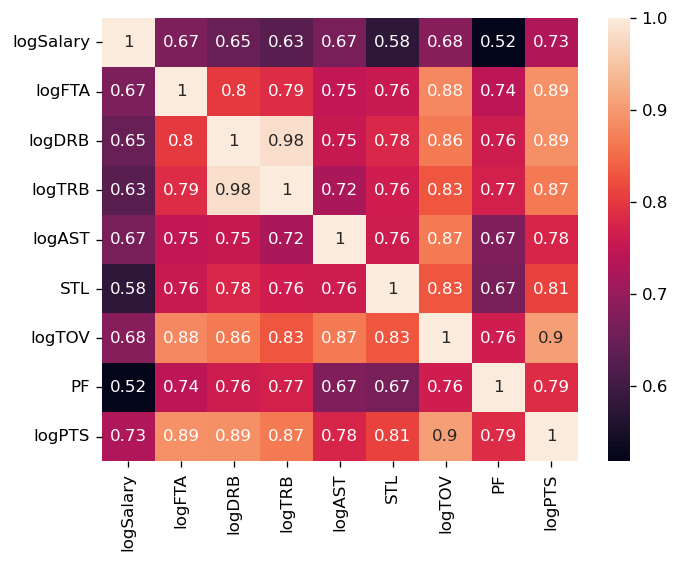

In [8]:
corrC2 = center[['logSalary', 'logFTA','logDRB', 'logTRB', 'logAST', 'STL','logTOV', 'PF', 'logPTS']].corr()
_ = sns.heatmap(corrC2, annot=True)  

# Forward

In [25]:
y_varF = forward['logSalary'].reset_index()
X_dataF2_ar = np.array([forward['Age'], forward['G'], forward['GS'], forward['MP'], 
                       forward['logFG'], forward['logFGA'],
                       forward['log2P'], forward['log2PA'], forward['logFT'], forward['logFTA'], 
                       forward['logDRB'], forward['logTRB'], forward['logAST'], forward['STL'], 
                       forward['logTOV'], forward['PF'], forward['logPTS']])
X_dataF2_T = X_dataF2_ar.T
X_varF2 = pd.DataFrame(X_dataF2_T, columns = ['Age', 'G', 
                                            'GS', 'MP', 'logFG', 'logFGA', 
                                            'log2P', 'log2PA', 
                                            'logFT', 'logFTA',
                                            'logDRB', 'logTRB', 'logAST', 'STL', 
                                            'logTOV', 'PF', 'logPTS'])

In [9]:
y_varF = forward['logSalary'].values
X_dataF2_ar = np.array([forward['Age'], forward['G'], forward['GS'], forward['MP'], 
                       forward['logFG'], forward['logFGA'],
                       forward['log2P'], forward['log2PA'], forward['logFT'], forward['logFTA'], 
                       forward['logDRB'], forward['logTRB'], forward['logAST'], forward['STL'], 
                       forward['logTOV'], forward['PF'], forward['logPTS']])
X_dataF2_T = X_dataF2_ar.T
X_varF2 = pd.DataFrame(X_dataF2_T, columns = ['Age', 'G', 
                                            'GS', 'MP', 'logFG', 'logFGA', 
                                            'log2P', 'log2PA', 
                                            'logFT', 'logFTA',
                                            'logDRB', 'logTRB', 'logAST', 'STL', 
                                            'logTOV', 'PF', 'logPTS'])
#X_varC.index = y_varC['index']
print(y_varF)
display(X_varF2.head())
display(X_varF2.tail())
models_best = pd.DataFrame(columns=["RSS", "model"])
tic = time.time()
for i in range(1,6):
    models_best.loc[i] = getBest(y_varF['logSalary'], X_varF2, i)
    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    Fb = models_best[models_best['RSS']==models_best.RSS.max()].index.values
    print(models_best.loc[Fb[0], "model"].summary())


[15.43029893 12.59803703 16.27602359 16.7745706  16.05875628 16.26721197
 15.7328669  17.33695904 13.2353027  14.92896942 14.97755075 15.47691701
 13.2353027  15.3231372  13.2353027  13.2353027  14.7430312  14.45848855
 15.15987241 17.63629692 14.97863637 13.2353027  15.27558521 13.01239448
 15.38380142 14.42315214 16.46949366 15.66262021 17.67938129 15.52184285
 17.62625271 17.48597525 13.92844899 16.6487239  11.86043655 14.70383135
 17.67849772 14.75115009 14.71102699 14.47193981 14.19379767 14.69652887
 14.97755075 15.17684576 15.55770804 13.84456729 14.91412285 16.91857958
 12.20338403 12.83842097 15.3231372  17.27593102 13.92844899 17.00723539
 16.21340583 12.44671028 13.2353027  16.3412392  13.5400798  13.92844899
 15.61713125 15.72042638 14.51846251 16.54190991 16.57176288 17.06119765
 16.16688582 14.96601613 17.63629692 14.58793092 16.6371265  14.47338335
 13.2353027  17.13282646 15.8949521  17.19381413 14.28551419 13.2353027
 14.668484   15.94481312 14.86195338 13.92844899 16.

,Age,G,GS,MP,logFG,logFGA,log2P,log2PA,logFT,logFTA,logDRB,logTRB,logAST,STL,logTOV,PF,logPTS
0,20.0,18.0,0.0,3.7,0.470004,0.993252,0.182322,0.262364,0.095310,0.182322,0.262364,0.336472,0.262364,0.1,0.182322,0.2,0.955511
1,22.0,17.0,8.0,21.6,1.131402,1.648659,0.875469,1.193922,0.693147,0.916291,1.252763,1.504077,0.641854,0.4,0.405465,1.4,1.931521
2,28.0,82.0,4.0,24.5,1.902108,2.501436,1.704748,2.219203,0.788457,0.916291,1.902108,2.128232,0.832909,0.8,0.741937,2.3,2.694627
3,31.0,84.0,42.0,25.7,1.686399,2.406945,1.029619,1.481605,0.470004,0.530628,1.252763,1.435085,1.335001,0.8,0.788457,2.0,2.572612
4,31.0,76.0,3.0,22.1,1.098612,1.722767,0.641854,0.875469,0.470004,0.587787,1.252763,1.410987,1.131402,0.5,0.470004,1.3,1.887070


,Age,G,GS,MP,logFG,logFGA,log2P,log2PA,logFT,logFTA,logDRB,logTRB,logAST,STL,logTOV,PF,logPTS
196,22.0,43.0,30.0,27.3,1.547563,2.230014,1.193922,1.774952,0.788457,0.916291,1.335001,1.589235,0.916291,0.9,0.832909,2.0,2.397895
197,24.0,31.0,11.0,18.1,1.335001,1.945910,1.029619,1.386294,0.470004,0.530628,1.029619,1.223775,0.530628,0.4,0.530628,1.6,2.104134
198,23.0,60.0,2.0,12.4,0.955511,1.386294,0.916291,1.280934,0.336472,0.530628,0.916291,1.163151,0.641854,0.4,0.405465,1.7,1.547563
199,26.0,28.0,1.0,13.9,1.029619,1.609438,0.262364,0.587787,0.405465,0.405465,0.788457,0.875469,0.470004,0.2,0.530628,1.1,1.856298
200,26.0,4.0,0.0,16.0,0.405465,1.609438,0.000000,0.916291,0.000000,0.000000,1.098612,1.386294,0.262364,1.0,0.405465,0.8,0.916291


Total elapsed time: 0.06676506996154785 seconds.
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     221.2
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           3.88e-34
Time:                        01:26:31   Log-Likelihood:                -285.83
No. Observations:                 201   AIC:                             575.7
Df Residuals:                     199   BIC:                             582.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

Multicollinearity exists between [('logSalary', 'G'), ('logFT', 'logAST')].


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              logSalary   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     102.2
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           7.46e-47
Time:                        02:07:28   Log-Likelihood:                -247.71
No. Observations:                 201   AIC:                             505.4
Df Residuals:                     196   BIC:                             521.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1779      0.356     31.439      0.000      10.477      11.879
Age            0.0733      0.014      5.081      0.000       0.045       0.102
G              0.0247      0.003      7.699      0.000       0.018       0.031
logFT          0.7042      0.198      3.550      0.000       0.313       1.095
logAST         0.5432      0.221      2.460      0.015       0.108       0.979
==============================================================================
Omnibus:                        4.209   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.122   Jarque-Bera (JB):                4.078
Skew:                          -0.232   Prob(JB):                        0.130
Kurtosis:                       3.521   Cond. No.                         354.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Checking for required conditions for error variable:


1. Zero mean
H0: Errors have zero mean.
H1: Errors do not have zero mean.
mean = -0.0003
std. dev. = 1.0034
Number of observation = 201
Hypothesized mean = 0
Significant level = 0.05
t-stat = -0.0042
t critical value one tail = -1.6525
p-value (one-tail) = 0.4983
t critical value two tail = -1.9719
p-value (two-tail) = 0.9966
Since the p_value = 0.9966 > 0.05, we do not reject the null hypothesis.
That is, we do not have sufficient evidence to claim that the errors do not have zero mean.

2. Normality
H0: Errors are normally distributed.
H1: Errors are not normally distributed.
Shapiro-Wilk test for normality:
H0: The distribution is normal.
H1: The distribution is not normal.
For population = standarized residuals
Shapiro statistic = 0.990888 and p_value = 0.236840
Since the p_value = 0.2368 > 0.05, we do not reject the null hypothesis.
That is, we do not have sufficient evidence to claim that the distribution is not normal.


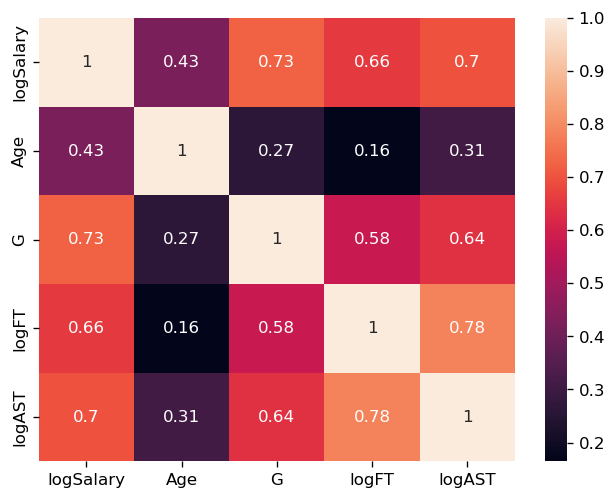

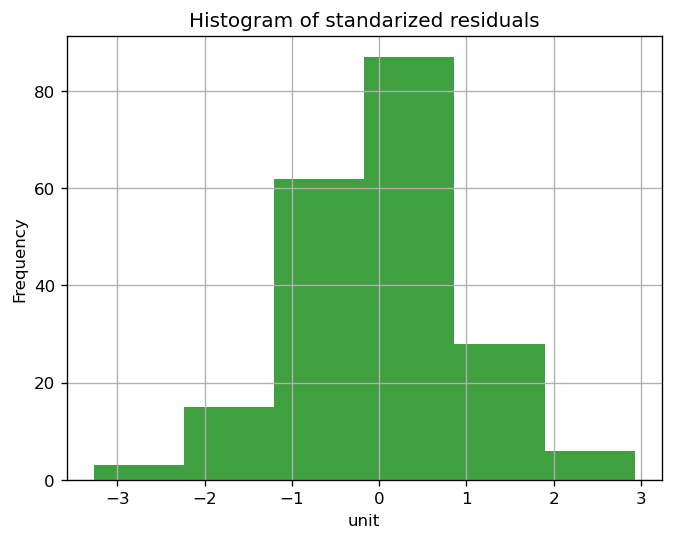

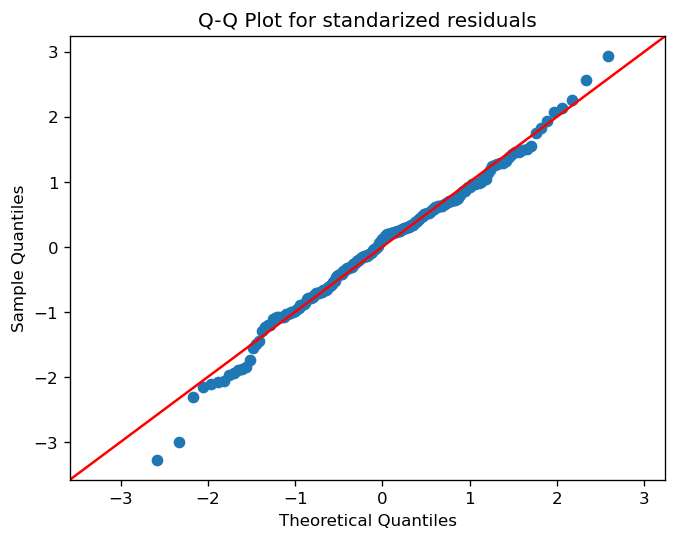


3. Homoskedasticity
H0: Homoskedasticity
H1: Heteroskedasticity


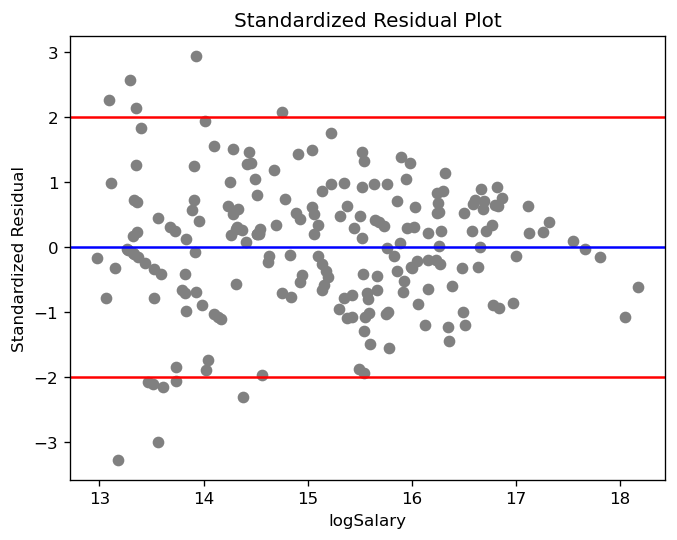

Do not rejected H0. Heteroscedasticity does not appear to be a problem.

4. Independence

4-1. Randomness
H0 : Randomness exists.
H1 : Randomness does not exist.
runs =  109
n1 =  101
n2 =  100
runs_exp =  101.49751243781094
stan_dev =  7.070803523557331
z =  1.0610516240754697
pval_z =  0.2886664408883812
p_value for Z-statistic=  0.2886664408883812
Since the p_value = 0.2887 > 0.05, we do not reject the null hypothesis.
That is, we do not have sufficient evidence to claim that randomness does not exist.

4-2. No Autocorrelation
H0 : There is no first-order correlation.
H1 : There is first-order correlation.
Outliers by SD = 

0      2.561397
26     2.077847
34    -2.163253
57     2.929734
67     2.254275
89    -2.086276
110   -3.010926
116   -2.068216
124   -3.272555
132   -2.315159
142   -2.106225
163    2.137707
Name: SD, dtype: float64

Outliers:
sample 1, sample 27, sample 35, sample 58, sample 68, sample 90, sample 111, sample 117, sample 125, sample 133, sample 143, sample 164.

/var/folders/v5/jn12r6jd76lc3czt8179yb400000gn/T/ipykernel_4921/738161940.py:218: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  H = np.matmul(X, np.linalg.solve(np.matmul(X.T, X), X.T))


In [27]:
F = np.array([forward["Age"], forward["G"],forward["logFT"], forward["logAST"]])
F = pd.DataFrame(F.T, columns = ["Age","G", "logFT", "logAST"])
alpha = 0.05
my_multiple_linear_regression(y_varF['logSalary'].T , F, 0.05)

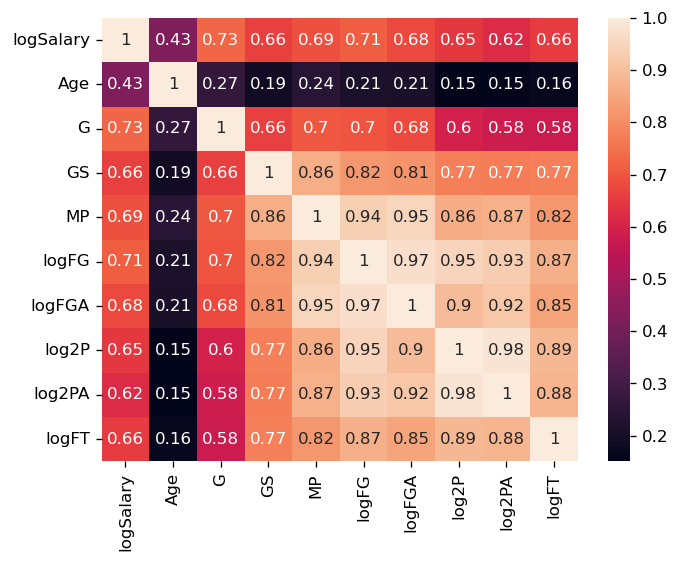

In [10]:
corrF1 = forward[['logSalary', 'Age', 'G','GS', 'MP', 'logFG', 'logFGA','log2P', 'log2PA', 'logFT']].corr()
_ = sns.heatmap(corrF1, annot=True)


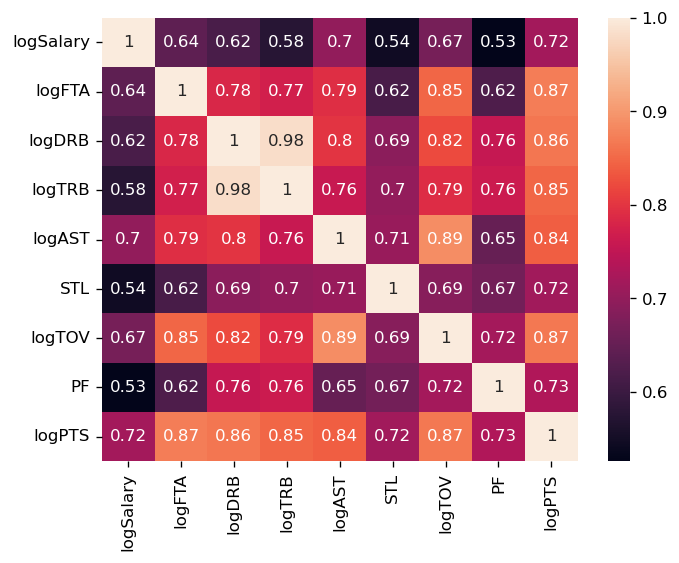

In [11]:
corrF2 = forward[['logSalary', 'logFTA','logDRB', 'logTRB', 'logAST', 'STL','logTOV', 'PF', 'logPTS']].corr()
_ = sns.heatmap(corrF2, annot=True)  

# guard

In [28]:
y_varG = guard['logSalary'].reset_index()
X_dataG2_ar = np.array([guard['Age'], guard['G'], guard['GS'], guard['MP'], 
                       guard['logFG'], guard['logFGA'],
                       guard['log2P'], guard['log2PA'], guard['logFT'], guard['logFTA'], 
                       guard['logDRB'], guard['logTRB'], guard['logAST'], guard['STL'], 
                       guard['logTOV'], guard['PF'], guard['logPTS'], guard['log3P']])
X_dataG2_T = X_dataG2_ar.T
X_varG2 = pd.DataFrame(X_dataG2_T, columns = ['Age', 'G', 
                                            'GS', 'MP', 'logFG', 'logFGA', 
                                            'log2P', 'log2PA', 
                                            'logFT', 'logFTA',
                                            'logDRB', 'logTRB', 'logAST', 'STL', 
                                            'logTOV', 'PF', 'logPTS', 'log3P'])

In [12]:
y_varG = guard['logSalary'].values
X_dataG2_ar = np.array([guard['Age'], guard['G'], guard['GS'], guard['MP'], 
                       guard['logFG'], guard['logFGA'],
                       guard['log2P'], guard['log2PA'], guard['logFT'], guard['logFTA'], 
                       guard['logDRB'], guard['logTRB'], guard['logAST'], guard['STL'], 
                       guard['logTOV'], guard['PF'], guard['logPTS'], guard['log3P']])
X_dataG2_T = X_dataG2_ar.T
X_varG2 = pd.DataFrame(X_dataG2_T, columns = ['Age', 'G', 
                                            'GS', 'MP', 'logFG', 'logFGA', 
                                            'log2P', 'log2PA', 
                                            'logFT', 'logFTA',
                                            'logDRB', 'logTRB', 'logAST', 'STL', 
                                            'logTOV', 'PF', 'logPTS', 'log3P'])
#X_varC.index = y_varC['index']
print(y_varG)
display(X_varG2.head())
display(X_varG2.tail())
models_best = pd.DataFrame(columns=["RSS", "model"])
tic = time.time()
for i in range(1,6):
    models_best.loc[i] = getBest(y_varG['logSalary'], X_varG2, i)
    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    Fb = models_best[models_best['RSS']==models_best.RSS.max()].index.values
    print(models_best.loc[Fb[0], "model"].summary())


[14.40871695 16.00436689 14.89701738 17.39352742 17.39011754 17.63629692
 17.50599422 14.97755075 14.42315214 16.70588232 17.11134742 14.35775578
 16.22345616 15.33504127 14.42315214 15.52746372 12.66121641 13.2353027
 13.90922128 13.12236338 17.33695904 14.35775578 14.10932727 12.23513132
 12.0465375  13.2353027  16.73779611 12.8211799  13.91082074 17.76513017
 14.61582462 14.85080562 16.72552932 12.04825442 15.43759615 15.18121438
 16.10762432 17.42268382 15.20180492 15.27649394 16.17418511 12.24095705
 14.50727578 12.50334731 15.12251168 12.39373409 16.50369391 11.98827105
 13.92250943 14.50865774 15.98055624 16.21842594 17.34202548 15.48158435
 15.22995496 15.02518826 14.74656063 15.17386213 17.42742897 15.24379775
 15.89603651 16.05531207 15.81887459 13.12236338 14.45398453 14.81240347
 13.07659165 14.5725265  12.24095705 11.16601696 16.09798743 15.16230575
 15.65824827 16.16688582 14.7802211  14.97755075 13.2353027  17.29982469
 15.02469774 14.7430312  13.2353027  16.92902587 15.

,Age,G,GS,MP,logFG,logFGA,log2P,log2PA,logFT,logFTA,logDRB,logTRB,logAST,STL,logTOV,PF,logPTS,log3P
0,23.0,40.0,0.0,14.2,1.252763,1.791759,1.064711,1.410987,0.587787,0.641854,0.788457,0.916291,1.435085,0.7,0.832909,1.5,1.987874,0.470004
1,28.0,75.0,74.0,33.5,1.704748,2.312535,1.029619,1.435085,0.993252,1.098612,1.458615,1.589235,1.386294,0.9,0.832909,2.1,2.674149,1.308333
2,22.0,82.0,4.0,20.2,1.308333,1.931521,1.064711,1.589235,0.741937,0.955511,1.335001,1.547563,0.955511,0.5,0.530628,1.7,2.116256,0.587787
3,32.0,66.0,66.0,32.7,2.116256,2.833213,1.547563,2.140066,0.993252,1.131402,1.547563,1.667707,1.722767,0.9,0.993252,1.9,3.044522,1.526056
4,34.0,72.0,72.0,34.3,1.774952,2.517696,1.193922,1.722767,1.648659,1.757858,1.740466,1.808289,2.251292,1.1,1.280934,1.8,2.867899,1.280934


,Age,G,GS,MP,logFG,logFGA,log2P,log2PA,logFT,logFTA,logDRB,logTRB,logAST,STL,logTOV,PF,logPTS,log3P
197,26.0,2.0,0.0,7.5,0.693147,1.098612,0.693147,0.916291,0.000000,0.000000,0.000000,0.405465,0.916291,0.0,0.405465,1.0,1.098612,0.000000
198,19.0,62.0,32.0,28.5,1.791759,2.631889,1.504077,2.251292,1.308333,1.458615,1.193922,1.410987,1.856298,0.8,1.481605,3.1,2.708050,0.875469
199,35.0,68.0,24.0,27.8,1.609438,2.312535,1.029619,1.458615,0.587787,0.641854,0.955511,1.029619,1.098612,1.0,0.741937,1.2,2.484907,1.163151
200,24.0,27.0,0.0,4.5,0.470004,0.832909,0.182322,0.336472,0.095310,0.095310,0.405465,0.405465,0.587787,0.1,0.262364,0.5,0.955511,0.262364
201,21.0,8.0,0.0,4.9,0.470004,0.916291,0.262364,0.470004,0.336472,0.405465,0.693147,0.832909,0.832909,0.1,0.262364,0.5,1.098612,0.336472


Total elapsed time: 0.0971071720123291 seconds.
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     283.7
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           3.24e-40
Time:                        01:27:17   Log-Likelihood:                -286.96
No. Observations:                 202   AIC:                             577.9
Df Residuals:                     200   BIC:                             584.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

Multicollinearity exists between [('logSalary', 'MP'), ('MP', 'logFTA')].


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              logSalary   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     107.0
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           2.81e-48
Time:                        02:09:29   Log-Likelihood:                -259.56
No. Observations:                 202   AIC:                             529.1
Df Residuals:                     197   BIC:                             545.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.5466      0.402     26.247      0.000       9.754      11.339
Age            0.0826      0.015      5.338      0.000       0.052       0.113
G              0.0168      0.003      5.264      0.000       0.011       0.023
MP             0.0471      0.013      3.667      0.000       0.022       0.073
logFTA         0.8384      0.205      4.081      0.000       0.433       1.244
==============================================================================
Omnibus:                        1.201   Durbin-Watson:                   2.142
Prob(Omnibus):                  0.548   Jarque-Bera (JB):                0.930
Skew:                           0.154   Prob(JB):                        0.628
Kurtosis:                       3.123   Cond. No.                         402.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Checking for required conditions for error variable:


1. Zero mean
H0: Errors have zero mean.
H1: Errors do not have zero mean.
mean = -0.0003
std. dev. = 1.0033
Number of observation = 202
Hypothesized mean = 0
Significant level = 0.05
t-stat = -0.0039
t critical value one tail = -1.6525
p-value (one-tail) = 0.4984
t critical value two tail = -1.9718
p-value (two-tail) = 0.9969
Since the p_value = 0.9969 > 0.05, we do not reject the null hypothesis.
That is, we do not have sufficient evidence to claim that the errors do not have zero mean.

2. Normality
H0: Errors are normally distributed.
H1: Errors are not normally distributed.
Shapiro-Wilk test for normality:
H0: The distribution is normal.
H1: The distribution is not normal.
For population = standarized residuals
Shapiro statistic = 0.995964 and p_value = 0.874441
Since the p_value = 0.8744 > 0.05, we do not reject the null hypothesis.
That is, we do not have sufficient evidence to claim that the distribution is not normal.


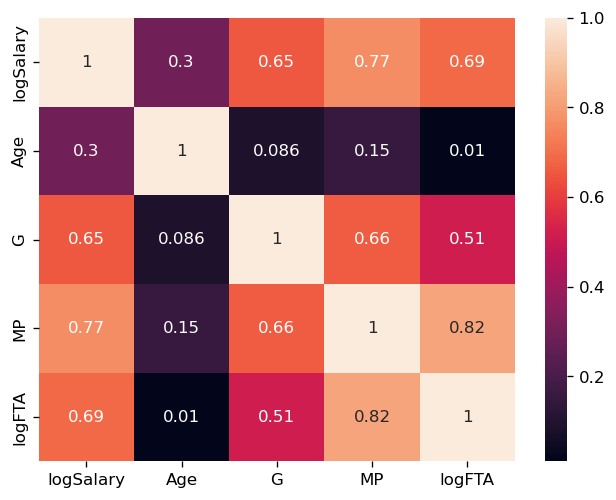

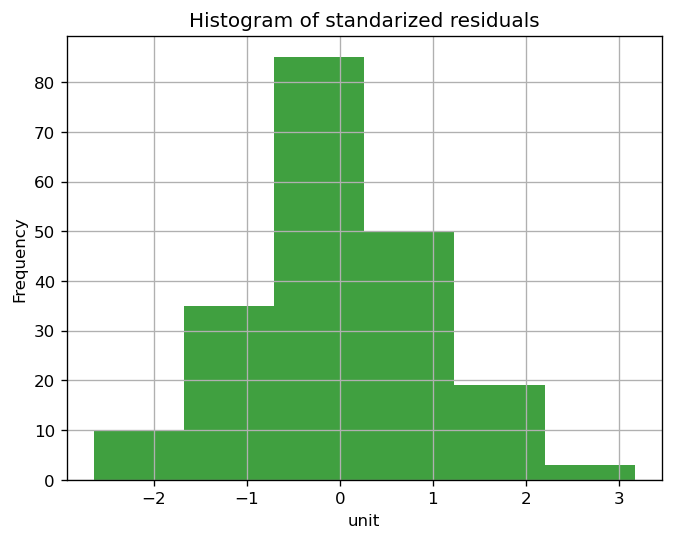

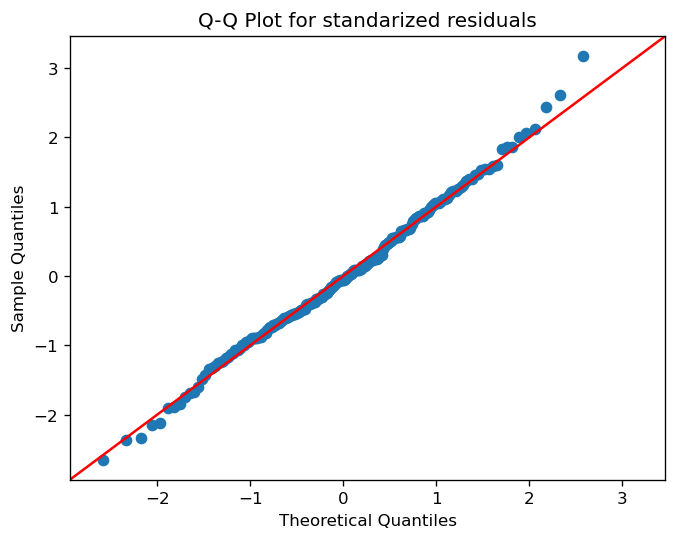


3. Homoskedasticity
H0: Homoskedasticity
H1: Heteroskedasticity


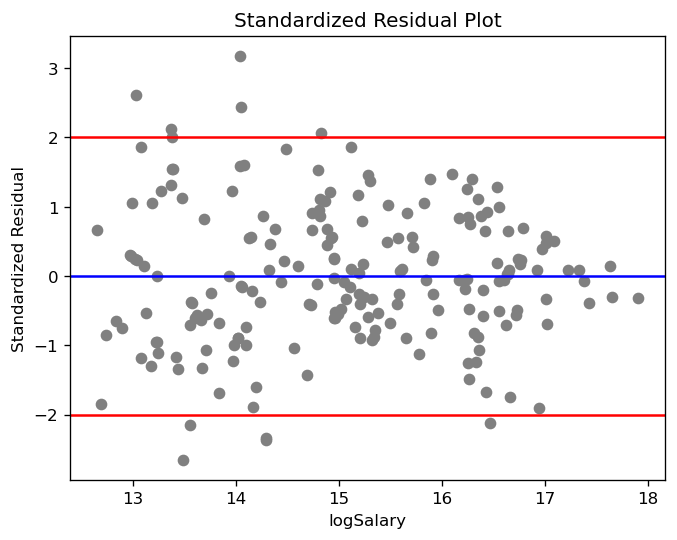

Do not rejected H0. Heteroscedasticity does not appear to be a problem.

4. Independence

4-1. Randomness
H0 : Randomness exists.
H1 : Randomness does not exist.
runs =  99
n1 =  101
n2 =  101
runs_exp =  102.0
stan_dev =  7.088635709281827
z =  -0.42321260719771703
pval_z =  0.6721401493594235
p_value for Z-statistic=  0.6721401493594235
Since the p_value = 0.6721 > 0.05, we do not reject the null hypothesis.
That is, we do not have sufficient evidence to claim that randomness does not exist.

4-2. No Autocorrelation
H0 : There is no first-order correlation.
H1 : There is first-order correlation.
Outliers by SD = 

13     2.619266
41    -2.341228
44     2.003290
68    -2.370427
69    -2.648907
73     2.446525
109   -2.151068
120    2.119622
154    3.171268
165    2.067458
178   -2.115424
Name: SD, dtype: float64

Outliers:
sample 14, sample 42, sample 45, sample 69, sample 70, sample 74, sample 110, sample 121, sample 155, sample 166, sample 179.
h_level =  0.07425742574257425
 

Infl

/var/folders/v5/jn12r6jd76lc3czt8179yb400000gn/T/ipykernel_4921/738161940.py:218: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  H = np.matmul(X, np.linalg.solve(np.matmul(X.T, X), X.T))


In [29]:
G = np.array([guard["Age"], guard["G"], guard["MP"], guard["logFTA"]])
G = pd.DataFrame(G.T, columns = ["Age","G", "MP", "logFTA"])
alpha = 0.05
my_multiple_linear_regression(y_varG['logSalary'].T , G, 0.05)